In [1]:
import numpy as np
import matplotlib.pyplot as plt

from numpy.lib.recfunctions import append_fields

from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

# Prepare Data

In [2]:
stock_name = 'AMZN'
Next_N_Day = 30

In [3]:
rec = np.genfromtxt('{}.csv'.format(stock_name), delimiter=',', names=True, dtype=None)

rec.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  """Entry point for launching an IPython kernel.


(5248,)

## Norm

In [4]:
rec['Close'] = rec['Close'].astype(np.int64)

rec['Close'] = (rec['Close'] - rec['Close'].mean()) / rec['Close'].std()
# rec['Close'] = (rec['Close'] - rec['Close'].min()) / (rec['Close'].max() -rec['Close'].min())

## Close Next N Day & Cut Last N Day

In [5]:
rec = append_fields(rec, 'Close_Next_N_Day', data=rec['Close'][Next_N_Day:])
rec = rec[:rec.shape[0] -Next_N_Day]

rec['Close'].shape, rec['Close_Next_N_Day'].shape

((5218,), (5218,))

## Shuffle

In [6]:
random_state = 0

np.random.seed(random_state)
np.random.shuffle(rec)

X, y = rec['Close'].reshape(-1, 1), rec['Close_Next_N_Day']

## Split

In [7]:
split_size = (0.7, 0.1, 0.2)

sample1 = int(split_size[0]*rec.shape[0])
sample2 = sample1 + int(split_size[1]*rec.shape[0])

X_train, X_validate, X_test = X[:sample1], X[sample1:sample2], X[sample2:]
y_train, y_validate, y_test = y[:sample1], y[sample1:sample2], y[sample2:]

X_train.shape, X_validate.shape, X_test.shape

((3652, 1), (521, 1), (1045, 1))

## Plot Dataset

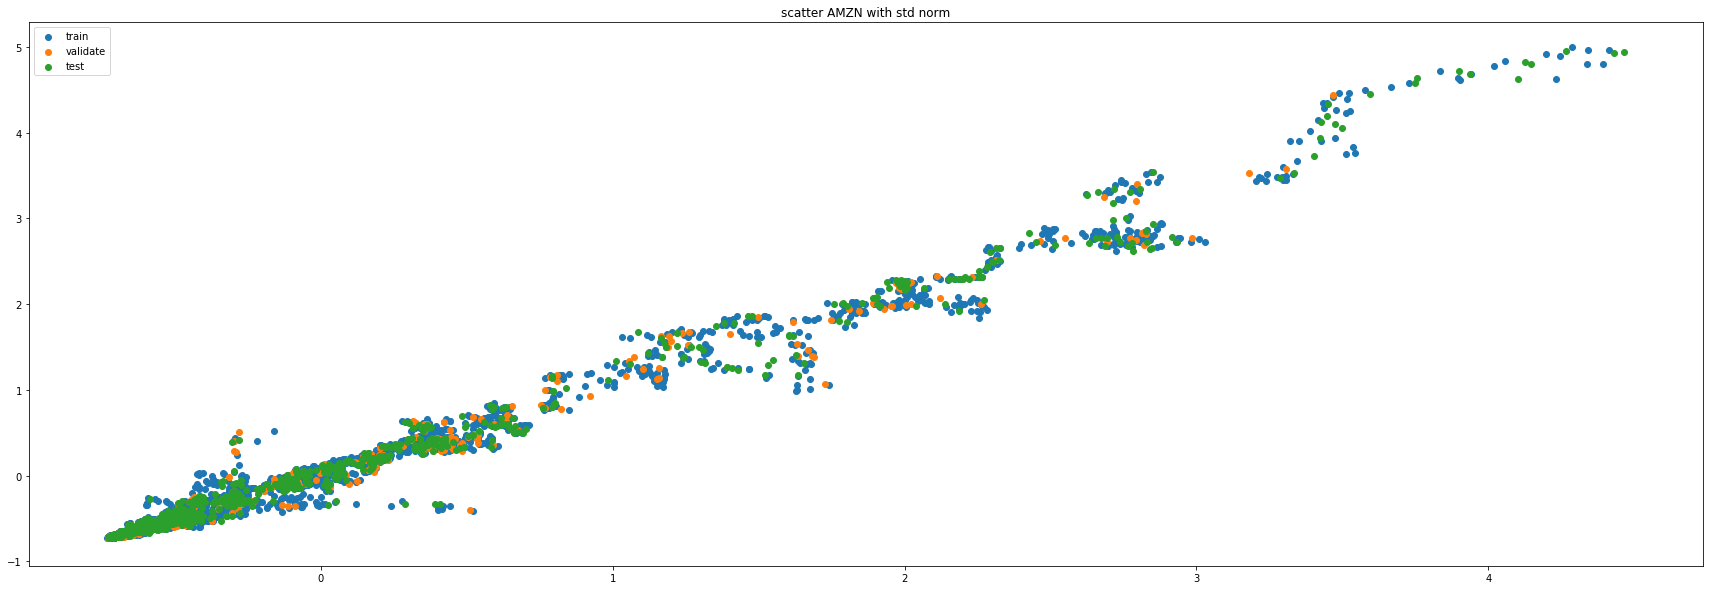

In [8]:
plt.figure(figsize=(30, 10))
plt.title('scatter AMZN with std norm')
plt.scatter(X_train, y_train, label='train')
plt.scatter(X_validate, y_validate, label='validate')
plt.scatter(X_test, y_test, label='test')
plt.legend()

# Cross Validation Prediction

In [9]:
kfold_split = 5

kfold = KFold(n_splits=kfold_split, shuffle=True, random_state=random_state)

In [10]:
svr_c = 1000
svr_gamma = 0.1
svr_degree = 2

lr = LinearRegression(n_jobs=-1)
svr_linear = SVR(kernel='linear', C=svr_c)
svr_rbf = SVR(kernel='rbf', C=svr_c, gamma=svr_gamma)
svr_poly = SVR(kernel='poly', C=svr_c, degree=svr_degree)

In [11]:
model = (lr, svr_linear, svr_rbf, svr_poly)
label = ('lr', 'svr_linear', 'svr_rbf', 'svr_poly')

## cross_val_score

In [12]:
cv_score = []
for i in model:
    print(f'running: {i.__class__}')
    score = cross_val_score(i, X_train, y_train, cv=kfold, n_jobs=-1)
    cv_score.append(score)

running: <class 'sklearn.linear_model._base.LinearRegression'>
running: <class 'sklearn.svm._classes.SVR'>
running: <class 'sklearn.svm._classes.SVR'>
running: <class 'sklearn.svm._classes.SVR'>


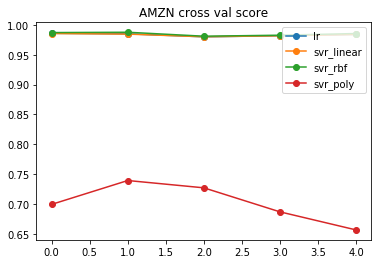

In [13]:
score_T = np.vstack(cv_score).T

plt.figure()
plt.title('AMZN cross val score')
plot = plt.plot(score_T, marker='o')
plt.legend(plot, label, loc=1)

([<matplotlib.axis.XTick at 0x7f6eb7f9b780>,
 <a list of 4 Text xticklabel objects>)

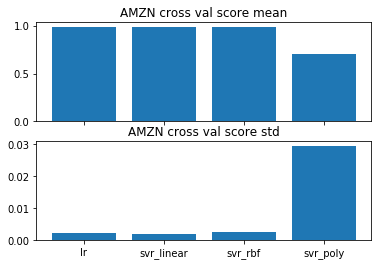

In [14]:
fig, ax = plt.subplots(nrows=2, sharex=True)
ax[0].title.set_text('AMZN cross val score mean')
ax[0].bar(np.arange(score_T.shape[1]), score_T.mean(axis=0))
ax[1].title.set_text('AMZN cross val score std')
ax[1].bar(np.arange(score_T.shape[1]), score_T.std(axis=0))
plt.xticks(np.arange(len(label)), label)

In [15]:
mse_val = []
r2s_val = []
mse_test = []
r2s_test = []

pred_val = []
pred_test = []

for i in model:
    i.fit(X_train, y_train)

    y_hat = i.predict(X_validate)
    pred_val.append(y_hat)
    mse_val.append(mean_squared_error(y_validate, y_hat))
    r2s_val.append(r2_score(y_validate, y_hat))

    y_hat = i.predict(X_test)
    pred_test.append(y_hat)
    mse_test.append(mean_squared_error(y_test, y_hat))
    r2s_test.append(r2_score(y_test, y_hat))

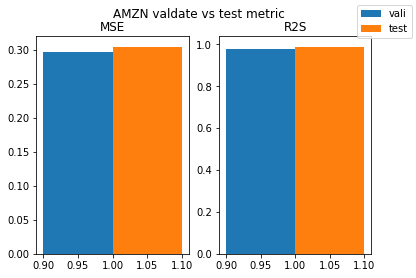

In [16]:
width = 0.1

fig, ax = plt.subplots(ncols=2)
plt.suptitle('AMZN valdate vs test metric')
ax[0].title.set_text('MSE')
ax[0].bar(1 - width/2, (mse_val), width, label='vali')
ax[0].bar(1 + width/2, (mse_test), width, label='test')
ax[1].title.set_text('R2S')
ax[1].bar(1 - width/2, (r2s_val), width)
ax[1].bar(1 + width/2, (r2s_test), width)
fig.legend()

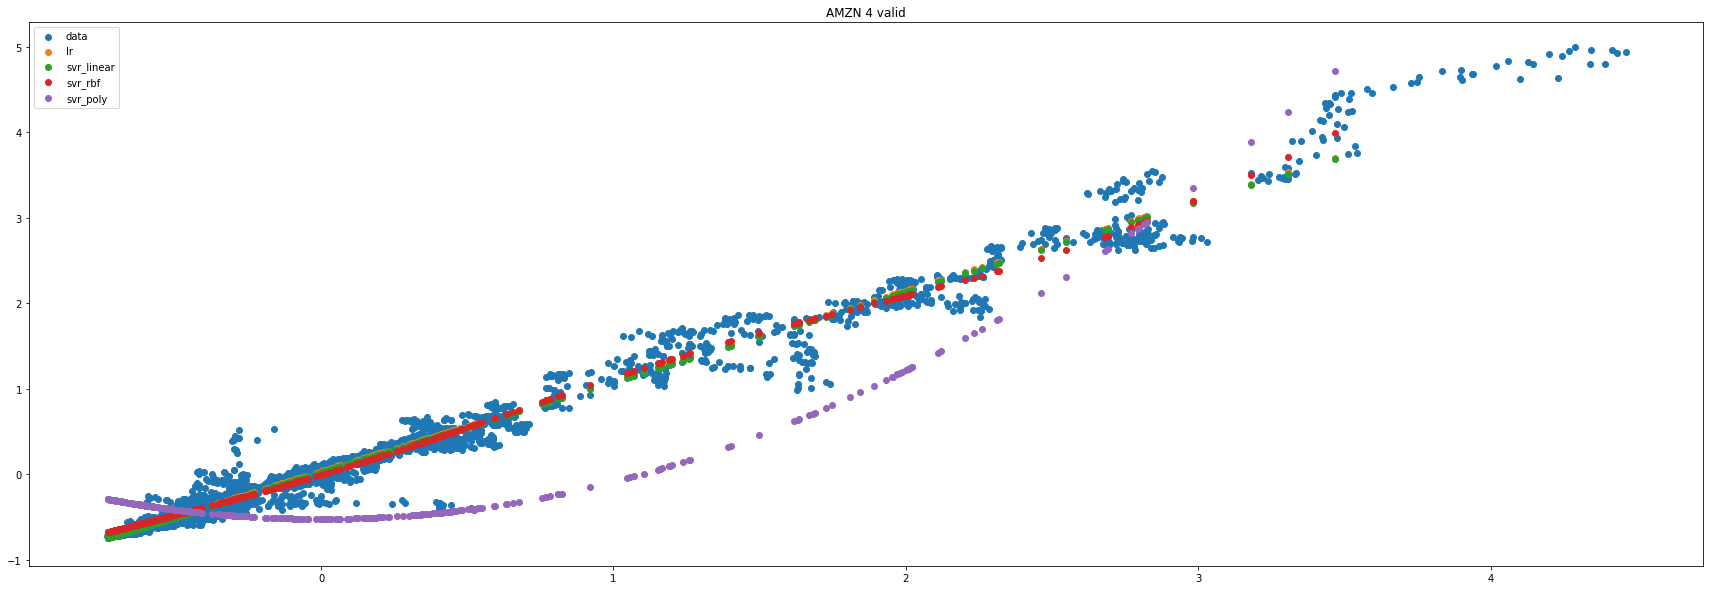

In [17]:
plt.figure(figsize=(30, 10))
plt.title('AMZN 4 valid')
plt.scatter(X, y, label='data')
plt.scatter(X_validate, pred_val[0], label='lr')
plt.scatter(X_validate, pred_val[1], label='svr_linear')
plt.scatter(X_validate, pred_val[2], label='svr_rbf')
plt.scatter(X_validate, pred_val[3], label='svr_poly')
plt.legend()

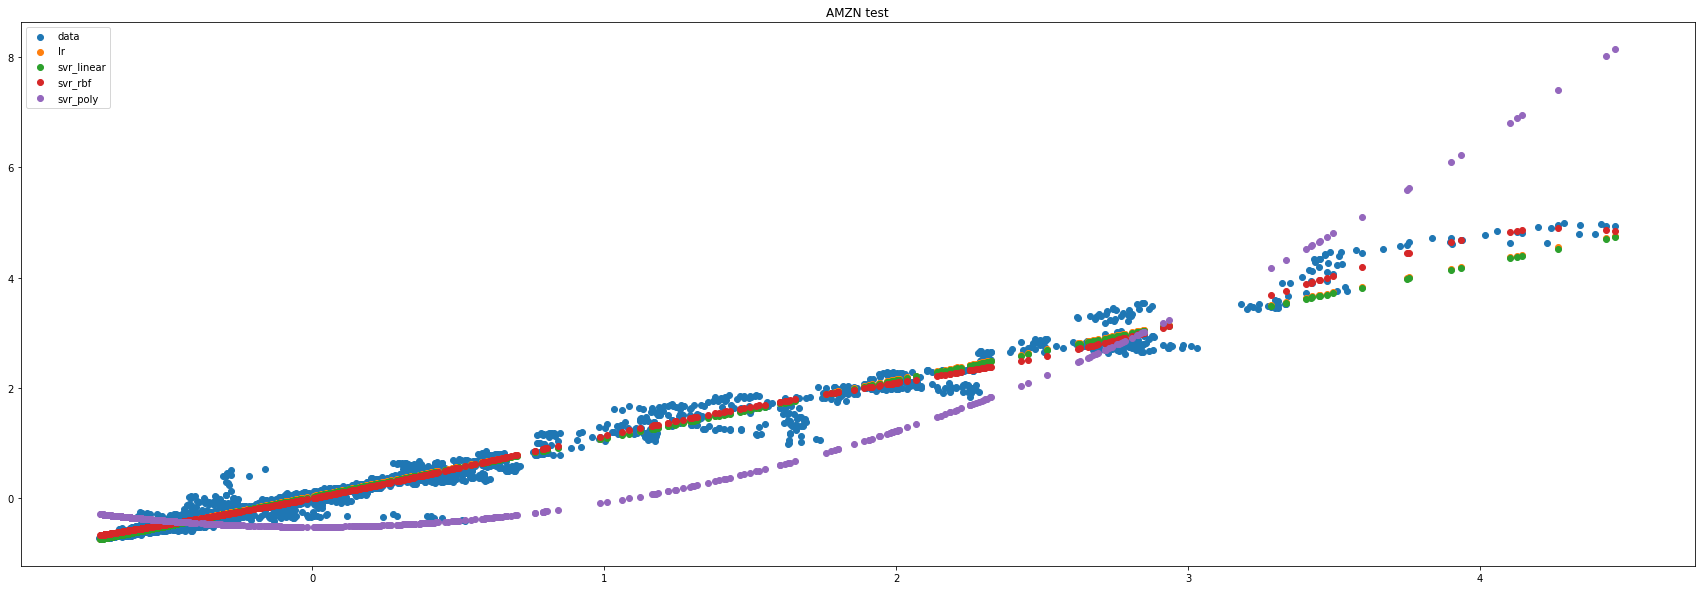

In [18]:
plt.figure(figsize=(30, 10))
plt.title('AMZN test')
plt.scatter(X, y, label='data')
plt.scatter(X_test, pred_test[0], label='lr')
plt.scatter(X_test, pred_test[1], label='svr_linear')
plt.scatter(X_test, pred_test[2], label='svr_rbf')
plt.scatter(X_test, pred_test[3], label='svr_poly')
plt.legend()

# GridSearchCV

In [19]:
param_grid = [{
    'kernel': ['rbf'],
    'C': [0.1, 1, 100, 1000],
    'gamma': [0.1, 0.5, 1]
}]

In [20]:
gsCV_svr = GridSearchCV(estimator=SVR(), param_grid=param_grid, cv=kfold, n_jobs=-1)

In [21]:
gsCV_svr.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid=[{'C': [0.1, 1, 100, 1000], 'gamma': [0.1, 0.5, 1],
                          'kernel': ['rbf']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [22]:
gsCV_svr.best_params_, gsCV_svr.best_score_

({'C': 1000, 'gamma': 1, 'kernel': 'rbf'}, 0.9856418858226933)

In [23]:
gsCV_svr.fit(X_train, y_train)

y_hat = gsCV_svr.predict(X_validate)
pred_val = y_hat
mse_val = mean_squared_error(y_validate, y_hat)
r2s_val = r2_score(y_validate, y_hat)

y_hat = gsCV_svr.predict(X_test)
pred_test = y_hat
mse_test = mean_squared_error(y_test, y_hat)
r2s_test = r2_score(y_test, y_hat)

mse_val, mse_test, r2s_val, r2s_test

(0.015678237546402563,
 0.012320407815090575,
 0.98120802773896,
 0.9890689844800442)

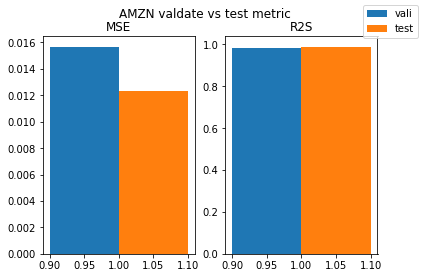

In [24]:
width = 0.1

fig, ax = plt.subplots(ncols=2)
plt.suptitle('AMZN valdate vs test metric')
ax[0].title.set_text('MSE')
ax[0].bar(1 - width/2, (mse_val), width, label='vali')
ax[0].bar(1 + width/2, (mse_test), width, label='test')
ax[1].title.set_text('R2S')
ax[1].bar(1 - width/2, (r2s_val), width)
ax[1].bar(1 + width/2, (r2s_test), width)
fig.legend()

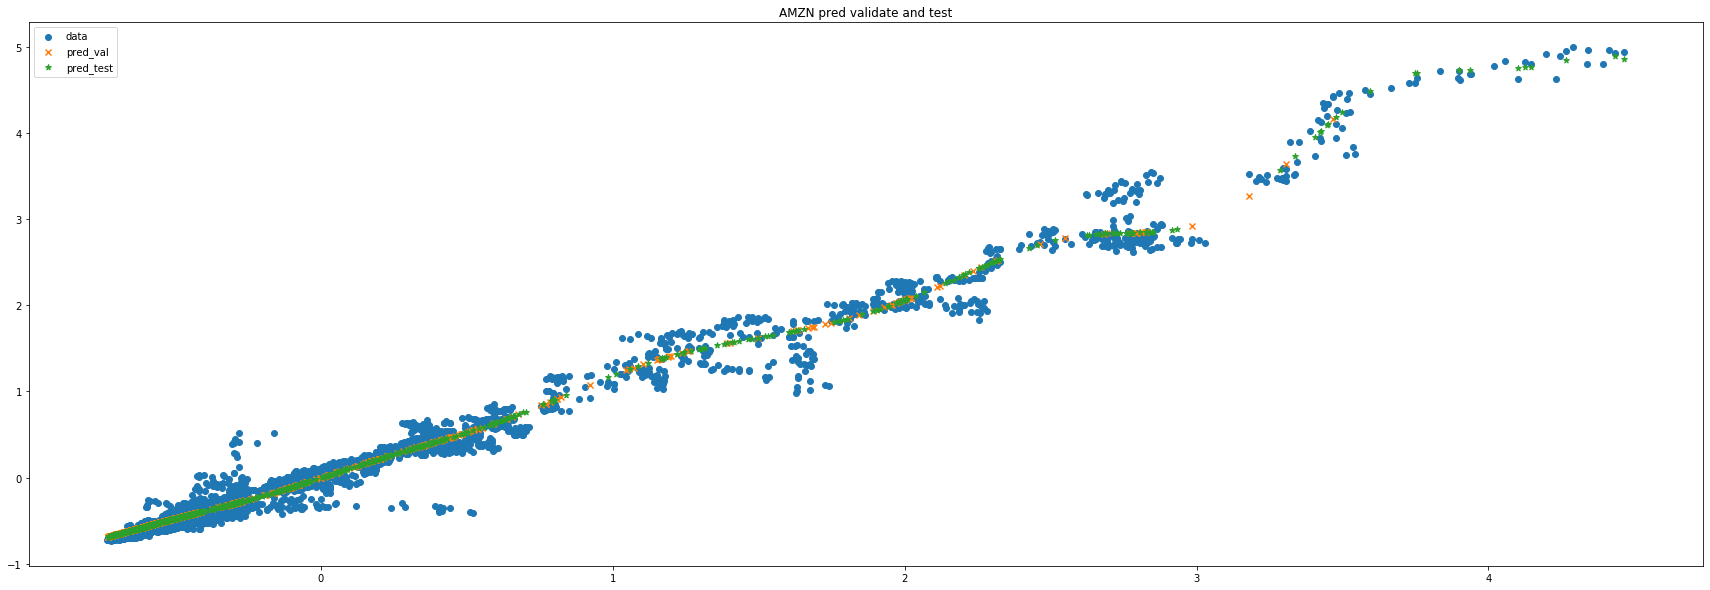

In [25]:
plt.figure(figsize=(30, 10))
plt.title('AMZN pred validate and test')
plt.scatter(X, y, label='data')
plt.scatter(X_validate, pred_val, marker='x', label='pred_val')
plt.scatter(X_test, pred_test, marker='*', label='pred_test')
plt.legend()